# ДЗ 1

# Задание 3

Реализуйте регулеризованый LDA с двумя параметрами из лекции. Сравните его с логистической рергерссией (осуществите тюнинг гиперпараметров для обоих моделей) на публичных датасетах (хотя бы 5) из UCI (https://archive.ics.uci.edu/).

**Дополнительно**: постарайтесь найти датасеты, где LDA работает лучше и попробуйте объяснить почему.

Подсказка: если данных достаточно много, то LDA и LogReg не будут отличаться даже если предположения LDA выполняются - попробуйте уменьшать обучающую выборку чтобы найти ситуации, когда LDA работает лучше. Если не получается с публичными датасетами - сгенерируйте (в этом случае посчитайте bias и variance для LDA и LorReg).

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


class RegularizedLDA(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0, beta=0):
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        
        pi_k = []
        mu_k = []
        cov_k = []
        for c in self.classes_:
            X_c = X[y == c]
            pi_k.append(len(X_c) / len(X))
            mu_k.append(X_c.mean(axis=0))
            cov_k.append(np.cov(X_c, rowvar=False))
        self.pi_k = np.array(pi_k)
        self.mu_k = np.array(mu_k)
        self.cov_k = np.array(cov_k)

        
        sigma = np.zeros((n_features, n_features))
        for k in range(n_classes):
            sigma += np.sum(y == self.classes_[k]) * self.cov_k[k]
        sigma /= (X.shape[0] - n_classes)
        
        diag_sigma = np.diag(np.diag(sigma))  
        sigma = self.beta * sigma + (1 -self.beta) * diag_sigma

        sigma_regularized = np.zeros_like(self.cov_k)
        for k in range(n_classes):
            sigma_regularized[k] = self.alpha * self.cov_k[k] + (1 - self.alpha) * sigma
        self.sigma = sigma_regularized
        
        return self

    def predict(self,X):    
        scores = []
        for k in range(len(self.classes_)):
            inv_sigma_k = np.linalg.inv(self.sigma[k])
            delta = X @ inv_sigma_k @ self.mu_k[k] - 0.5 * self.mu_k[k].T @ inv_sigma_k @ self.mu_k[k] + np.log(self.pi_k[k])
            scores.append(delta)
        scores = np.array(scores).T
        return self.classes_[np.argmax(scores, axis=1)]

In [2]:
dataset_names = ["iris", "adult", "spambase", "wine", "banknote-authentication"]

datasets = []
for name in dataset_names:
    data = fetch_openml(name, as_frame=True, parser="pandas")
    X = data.data
    y = data.target.astype("category").cat.codes
    datasets.append((name, X, y))

lda_params = {'alpha': np.linspace(0, 1, 10), 'beta': np.linspace(0, 1, 10)}
logreg_params = {'C': np.logspace(-10, 10, 10)}


best_models = {}

for name, X, y in datasets:
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns

    for col in cat_cols:
         X[col] = LabelEncoder().fit_transform(X[col])
    
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)
    else:
        y = y.astype(int)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=424, stratify=y)

    
    lda = RegularizedLDA()
    lda_gs = GridSearchCV(lda, param_grid=lda_params, cv=StratifiedKFold(5), scoring="accuracy")
    lda_gs.fit(X_train, y_train)
    lda_best = lda_gs.best_estimator_
    lda_pred = lda_best.predict(X_test)
    lda_acc = accuracy_score(y_test, lda_pred)

    logreg = LogisticRegression(solver="lbfgs", max_iter=1000, multi_class="auto")
    logreg_gs = GridSearchCV(logreg, param_grid=logreg_params, cv=StratifiedKFold(5), scoring="accuracy")
    logreg_gs.fit(X_train, y_train)
    logreg_best = logreg_gs.best_estimator_
    logreg_pred = logreg_best.predict(X_test)
    logreg_acc = accuracy_score(y_test, logreg_pred)

    best_models[name] = {'lda_best_params': lda_gs.best_params_, 'logreg_best_params': logreg_gs.best_params_}
    
    print(f"Dataset: {name}")
    print(f"LDA best accuracy: {lda_acc}, with params: {lda_gs.best_params_:}")
    print(f"Logreg best accuracy: {logreg_acc}, with params: {logreg_gs.best_params_:}", end = '\n\n')


C:\Users\chesn\miniconda3\envs\ml_py11_torchvision\Lib\site-packages\sklearn\datasets\_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=61
- version 3, status: active
  url: https://www.openml.org/search?type=data&id=969

  warn(warning_msg)
C:\Users\chesn\miniconda3\envs\ml_py11_torchvision\Lib\site-packages\sklearn\datasets\_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=179
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=1590

  warn(warning_msg)
C:\Users\chesn\miniconda3\envs\ml_py11_torchvision\Lib\site-packages\sklearn\datasets\_openml.p

Dataset: iris
LDA best accuracy: 0.9777777777777777, with params: {'alpha': 0.0, 'beta': 0.7777777777777777}
Logreg best accuracy: 0.9555555555555556, with params: {'C': 359381.36638046405}

Dataset: adult
LDA best accuracy: 0.8267249027502901, with params: {'alpha': 0.1111111111111111, 'beta': 0.7777777777777777}
Logreg best accuracy: 0.824814031256398, with params: {'C': 12.915496650148826}

Dataset: spambase
LDA best accuracy: 0.9333816075307748, with params: {'alpha': 0.7777777777777777, 'beta': 0.4444444444444444}
Logreg best accuracy: 0.9341057204923968, with params: {'C': 12.915496650148826}

Dataset: wine
LDA best accuracy: 0.9814814814814815, with params: {'alpha': 0.0, 'beta': 0.8888888888888888}
Logreg best accuracy: 0.9629629629629629, with params: {'C': 2154.4346900318865}

Dataset: banknote-authentication
LDA best accuracy: 0.9854368932038835, with params: {'alpha': 1.0, 'beta': 0.0}
Logreg best accuracy: 0.9927184466019418, with params: {'C': 2154.4346900318865}



" iris " Dataset size = 150


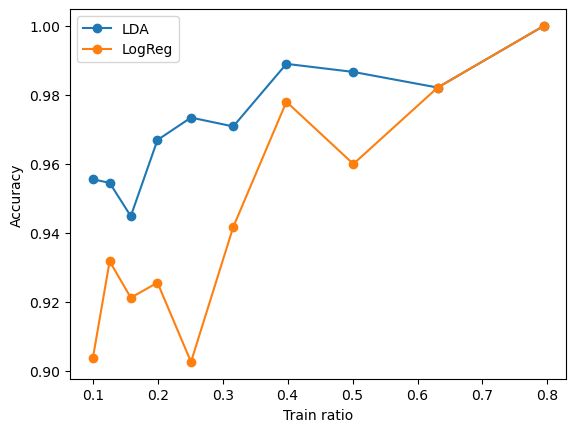

In [3]:
name, X, y = datasets[0]

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
     X[col] = LabelEncoder().fit_transform(X[col])

if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)
else:
    y = y.astype(int)

lda_scores = []
logreg_scores = []
train_rations = np.logspace(-1, -0.1, 10)
for train_ratio in train_rations:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=44, stratify=y)

    lda = RegularizedLDA(**best_models[name]['lda_best_params'])
    lda.fit(X_train, y_train)
    lda_scores.append(accuracy_score(y_test, lda.predict(X_test)))
        
    lr = LogisticRegression(solver="lbfgs", max_iter=1000, multi_class="auto", **best_models[name]['logreg_best_params'])
    lr.fit(X_train, y_train)
    logreg_scores.append(accuracy_score(y_test, lr.predict(X_test)))

print('"', name, '"', 'Dataset size =', X.shape[0])
plt.plot(train_rations, lda_scores, label='LDA', marker = 'o')
plt.plot(train_rations, logreg_scores, label='LogReg', marker = 'o')
plt.xlabel('Train ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Как видно при маленьком размере датасета lda может работать эффективнее, так как использует предположения о распределении данных, а у логистической регрессии может не хватать данных для хорошей оценки